In [53]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib import rc
from IPython import display


rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
path = "rt-polaritydata/rt-polaritydata/"

pos_path = os.path.join(path, 'rt-polarity.pos')
neg_path = os.path.join(path, 'rt-polarity.neg')

def load_review(path, is_pos=True):
    with open(path, encoding='latin-1') as f:
        review = pd.DataFrame({'review':f.read().splitlines()})
    review['sentiment'] = 1 if is_pos else 0
    return review

pos_review = load_review(pos_path, is_pos=True)
neg_review = load_review(neg_path, is_pos=False)

all_reviews = pd.concat([pos_review, neg_review])
all_reviews.head()

,review,sentiment
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [3]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin", binary=True)

In [6]:
from stop_words import get_stop_words

MAX_WORDS = 10
EMBEDDING_SIZE = 300

def process_review_dense(review, max_words=MAX_WORDS):
    review = tf.keras.preprocessing.text.text_to_word_sequence(review)
    review = [word for word in review if word not in get_stop_words('english')]
    review_ = []
    for r in review:
        try:
            review_.append(word2vec_model[r])
        except KeyError:
            pass # word not found in the model
    review_ = review_[:max_words]
    return np.sum(np.asarray(review_), axis=0) 

In [7]:
def process_review_conv(review, max_words=MAX_WORDS):
    review = tf.keras.preprocessing.text.text_to_word_sequence(review)
    review = [word for word in review if word not in get_stop_words('english')]
    review_ = []
    for r in review:
        try:
            review_.append(word2vec_model[r])
        except KeyError:
            review_.append(np.zeros(EMBEDDING_SIZE,)) # when word does not exist in vocab
    while len(review_) < max_words:
        review_.append(np.zeros(EMBEDDING_SIZE,))
    review_ = review_[:max_words]
    return review_

In [8]:
processed_review_conv = all_reviews.review.apply(lambda review: process_review_conv(review))
processed_review_dense = all_reviews.review.apply(lambda review: process_review_dense(review))

In [36]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
        """
        Create F1 metric for Keras
        From: https://stackoverflow.com/a/45305384/9511702
        """
        def recall(y_true, y_pred):
            tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = tp / (possible_positives + K.epsilon())
            return recall
        
        def precision(y_true, y_pred):
            tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = tp / (predicted_positives + K.epsilon())
            return precision
        
        precision = precision(y_true, y_pred)
        recall = recall(y_true, y_pred)
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    
def build_model():
    concat_size = 128    
    # convolutional part of the model
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(EMBEDDING_SIZE, MAX_WORDS, 1))
    pool1 = tf.keras.layers.MaxPool2D((2, 2))
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
    pool2 = tf.keras.layers.MaxPool2D((2, 2))
    dense1 = tf.keras.layers.Dense(512, activation='relu')
        
    # dense part of the model
    dense2 = tf.keras.layers.Dense(256, activation='relu', input_shape=(EMBEDDING_SIZE,))
    dense3 = tf.keras.layers.Dense(128, activation='relu')
    dense4 = tf.keras.layers.Dense(64, activation='relu')
        
    concat_layer1 = tf.keras.layers.Dense(10, activation='relu')
    concat_layer2 = tf.keras.layers.Dense(10, activation='relu')
    dense5 = tf.keras.layers.Dense(1, activation='sigmoid')
    dropout = tf.keras.layers.Dropout(0.4)
    batch_norm = tf.keras.layers.BatchNormalization()
    
    X_conv_in = tf.keras.Input(shape=(EMBEDDING_SIZE, MAX_WORDS, 1))
    X_dense_in = tf.keras.Input(shape=(EMBEDDING_SIZE,))
        
    X_conv = conv1(X_conv_in)
    X_conv = pool1(X_conv)
    X_conv = conv2(X_conv)
    X_conv = pool2(X_conv)
    X_conv = batch_norm(X_conv)
    X_conv = tf.keras.layers.Flatten()(X_conv)
    # X_conv = dropout(X_conv)
    X_conv = dense1(X_conv)
    X_conv = concat_layer1(X_conv)
        
    X_dense = dense2(X_dense_in)
    # X_dense = dropout(X_dense)
    X_dense = dense3(X_dense)
    # X_dense = dropout(X_dense)
    X_dense = dense4(X_dense)
    X_dense = concat_layer2(X_dense)
    
    X = tf.concat([X_conv, X_dense], axis=1)
    X = dense5(X)
    
    model = tf.keras.Model(inputs=[X_conv_in, X_dense_in], outputs=X, name='cnn_and_dense_model')
    metrics = ['accuracy', tf.keras.metrics.AUC(), f1] 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    return model

In [56]:
import logging
logging.getLogger('tensorflow').disabled = True

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)    
    
def train(X_dense_train, X_conv_train, y_train, X_dense_test, X_conv_test, 
          y_test, epochs=30, batch_size=32):
    model = build_model()
    history = model.fit((X_conv_train, X_dense_train), 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=((X_conv_test, X_dense_test), y_test),
                        callbacks=[early_stopping],
                        verbose=0)
    test_results = model.evaluate((X_conv_test, X_dense_test), y_test, batch_size)
    return history.history, model, test_results

In [57]:
from sklearn.model_selection import StratifiedKFold

def X_conv_transform(X_conv):
    X_conv = tf.convert_to_tensor(X_conv)
    # one channel (black or white)
    X_conv = tf.reshape(X_conv, [X_conv.shape[0], X_conv.shape[2], X_conv.shape[1], 1])
    return X_conv

def X_dense_transform(X_dense):
    X_dense_reshaped = np.zeros([len(X_dense), X_dense[0].shape[0]])
    for i in range(len(X_dense)):
        X_dense_reshaped[i, :] = X_dense[i]
    return tf.convert_to_tensor(X_dense_reshaped)

def y_transform(y):
    return tf.convert_to_tensor(y)

def cross_validate(X_dense, X_conv, y, split_size=3):
    results = []
    models = []
    test_results = []
    kf = StratifiedKFold(n_splits=split_size)
    for train_idx, val_idx in kf.split(X_conv, y):
        X_train_conv = X_conv_transform(X_conv[train_idx])
        X_train_dense = X_dense_transform(X_dense[train_idx])
        y_train = y_transform(y[train_idx])
        X_test_conv = X_conv_transform(X_conv[val_idx])
        X_test_dense = X_dense_transform(X_dense[val_idx])
        y_test = y_transform(y[val_idx])
        
        result, model, test_result = train(X_train_dense, X_train_conv, y_train, X_test_dense, X_test_conv, y_test)
        results.append(result)
        models.append(model)
        test_results.append(test_result)
    return results, models, test_results

In [58]:
X_conv = np.array(processed_review_conv.to_numpy().tolist())
X_dense = np.asarray(processed_review_dense).flatten()

y = all_reviews.sentiment.values
y_new = np.array(y)

In [59]:
results, models, test_results = cross_validate(X_dense, X_conv, y_new)

3565/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [60]:
test_results

[[1.3801986588000583, 0.7332398, 0.7815198, 0.3892549],
 [1.4137357155286914, 0.70490885, 0.76193154, 0.38923898],
 [1.284576772255784, 0.7312763, 0.7895209, 0.4095965]]

In [61]:
def predict(model, review, max_words=MAX_WORDS, shape=(EMBEDDING_SIZE,)):
    def process_input(review, fn, shape):
        input_ = [p for p in fn(review)]
        input_ = tf.cast(input_, tf.float32)
        input_ = tf.reshape(input_, shape)
        input_ = input_[np.newaxis, ...]
        return input_
    
    input_conv = process_input(review, process_review_conv, shape=(EMBEDDING_SIZE, MAX_WORDS, 1))
    input_dense = process_input(review, process_review_dense, shape=(EMBEDDING_SIZE,))
    prediction = model.predict((input_conv, input_dense))[0][0]
    print(prediction)
    if prediction > 0.5:
        print('Positive review with probability: {:.2f}%'.format(prediction * 100))
    else:
        print('Negative review with probability: {:.2f}%'.format(100 - prediction * 100))

In [62]:
predict(models[0], "The movie was so bad")

0.012607907
Negative review with probability: 98.74%


In [63]:
for i, model in enumerate(models):
    print(f"\nModel {i}: \n")
    predict(model, "I really like this film, one of the best I've ever seen")
    predict(model, 'I like this film and recommend to everyone.')
    predict(model, "The movie was terrible, not worth watching once again")


Model 0: 

0.79618233
Positive review with probability: 79.62%
0.97792065
Positive review with probability: 97.79%
0.057157353
Negative review with probability: 94.28%

Model 1: 

0.9722028
Positive review with probability: 97.22%
0.7223836
Positive review with probability: 72.24%
4.4896424e-05
Negative review with probability: 100.00%

Model 2: 

0.15895742
Negative review with probability: 84.10%
0.11225407
Negative review with probability: 88.77%
0.25145513
Negative review with probability: 74.85%


In [64]:
def plot_result(result):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    plt.plot(result['loss'], label='train')
    plt.plot(result['val_loss'], label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
    
    auc_metrics = []
    for key, value in result.items():
        if 'auc' in key:
            auc_metrics.append(key)
    plt.subplot(1, 4, 2)
    plt.plot(result[auc_metrics[0]], label='train')
    plt.plot(result[auc_metrics[1]], label='test')
    plt.xlabel('epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(result['f1'], label='train')
    plt.plot(result['val_f1'], label='test')
    plt.xlabel('epoch')
    plt.ylabel('$$F_1$$')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(result['accuracy'], label='train')
    plt.plot(result['val_accuracy'], label='test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

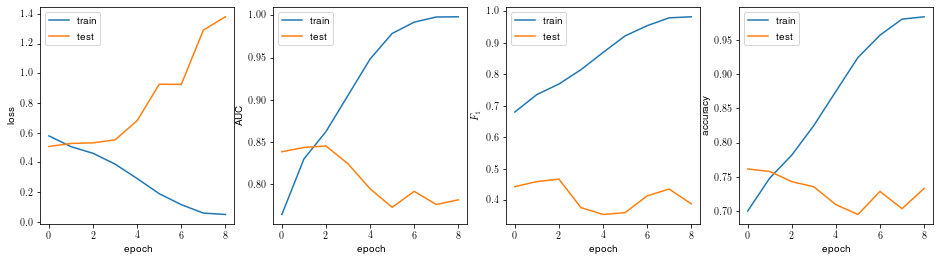

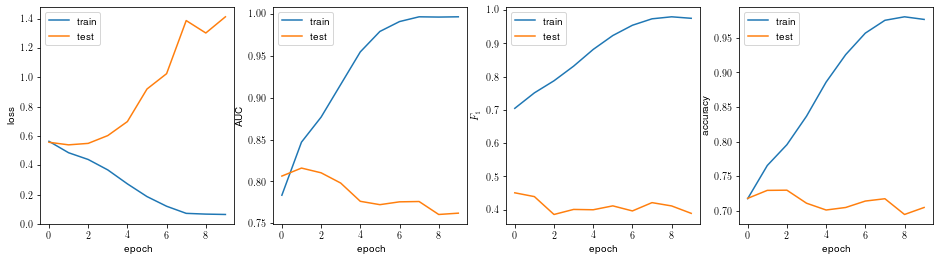

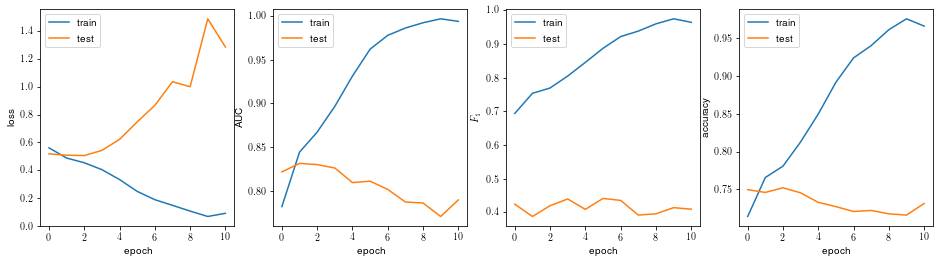

In [65]:
for result in results:
    plot_result(result)

In [92]:
from tensorflow.keras.utils import model_to_dot

def save_model_architecture(filename):
    dot_model = model_to_dot(build_model(), show_shapes=True, show_layer_names=False)
    dot_model.write_pdf(filename)

In [93]:
save_model_architecture('figures/cnn_dense_model.pdf')